In [5]:
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [3]:
datadir = "/home/weizmann.kiendrebeogo/DeepClean/DeepClean_CIT/Friday_Work/data"
dc_noise_only        = os.path.join(datadir, 'deepclean-NoiseOnly.gwf')
dc_noise_plus_signal = os.path.join(datadir, 'deepclean-NoisePlusSignal.gwf')
org_noise_only       = os.path.join(datadir, 'original-NoiseOnly.h5')
org_noise_plus_signal= os.path.join(datadir, 'original-NoisePlusSignal.h5')
signal_only          = os.path.join(datadir, 'GW_injected_signal.hdf5')
inj_file             = os.path.join(datadir, 'INJ-1265127585-4096.csv')
inj_file_json        = os.path.join(datadir, 'INJ-1265127585-4096.json')


channel = 'V1:Hrec_hoft_raw_20000Hz'  # Original Channel channel
channel_DC="V1:Hrec_hoft_raw_20000Hz_DC"  # Cleanning channel
channel_INJ = "V1:DC_INJ"                # Injected GW signal channel

injections = pd.read_csv(inj_file)


In [4]:
injections

,Unnamed: 0,mass_1,mass_2,luminosity_distance,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,dec,ra,theta_jn,psi,phase,geocent_time
0,0,21.657061,8.942829,20.337186,0.316401,0.421803,0.0,0.0,0.0,0.0,1.372350,0.351124,1.571572,1.093520,4.623716,1.265128e+09
1,1,17.544304,10.600881,29.596042,0.771905,0.188531,0.0,0.0,0.0,0.0,0.038757,3.129534,2.167390,0.874952,5.544598,1.265128e+09
2,2,18.290719,10.537260,21.154880,0.877212,0.908567,0.0,0.0,0.0,0.0,0.258815,4.949516,1.682590,0.478230,5.549510,1.265128e+09
3,3,16.838082,13.765906,19.765857,0.567760,0.365852,0.0,0.0,0.0,0.0,0.019673,4.494605,0.856310,0.637793,4.287117,1.265128e+09
4,4,19.579346,10.257479,16.910476,0.258311,0.717408,0.0,0.0,0.0,0.0,0.849165,1.901740,2.322145,2.245926,1.694800,1.265128e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,18.632911,10.719888,19.200438,0.697003,0.673823,0.0,0.0,0.0,0.0,-0.906635,1.968273,1.644622,2.709033,0.383454,1.265132e+09
124,124,19.045053,11.166912,26.226166,0.524494,0.254161,0.0,0.0,0.0,0.0,0.636787,1.319891,0.776720,0.102622,2.239597,1.265132e+09
125,125,18.719389,8.516774,26.472437,0.345161,0.712868,0.0,0.0,0.0,0.0,-0.680273,0.548604,1.571081,1.923266,0.022102,1.265132e+09
126,126,20.464251,8.719971,28.141396,0.650938,0.067115,0.0,0.0,0.0,0.0,0.942930,3.119290,1.293614,2.005906,3.245518,1.265132e+09


In [5]:
inj_idx = 10
injection_parameters = injections.iloc[inj_idx].to_dict()
param_dict = injection_parameters
param_dict


{'Unnamed: 0': 10.0,
 'mass_1': 13.909942065976097,
 'mass_2': 13.045624329101914,
 'luminosity_distance': 19.645249211791665,
 'a_1': 0.3332972363297479,
 'a_2': 0.7816245551500934,
 'tilt_1': 0.0,
 'tilt_2': 0.0,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'dec': 0.5223989018538194,
 'ra': 6.114564881024543,
 'theta_jn': 1.4717742545294368,
 'psi': 1.30225592550328,
 'phase': 5.496084823244368,
 'geocent_time': 1265127905.0}

In [6]:
param_dict['geocent_time']

1265127905.0

## plotting an examples of data 

(1265127904.901, 1265127905.011)

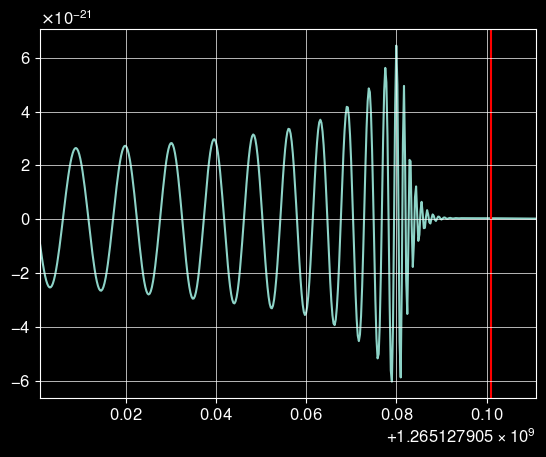

In [9]:
signal = TimeSeries.read(
            signal_only, 
            channel_INJ,
            start = param_dict['geocent_time']-4, 
            end = param_dict['geocent_time']+10
        )
plt.plot(signal)
plt.axvline(param_dict['geocent_time'] , color = 'red')
plt.xlim(param_dict['geocent_time']-0.1, param_dict['geocent_time']+0.01)

## There are some misplacements in the way the injections are placed 
We call this an artifact in the waveform placement in time which has probably been messed up. Right now we fix these offsets by estimating them empirically using a pe on the time parameter and then feeding that offset back to the time parameter in the prior while doing the pe for other parameters so that they are unbiased. 

## Why is it safe to do so?
First of all, this is estimated from a zero noise strain which has only injected signals and no noise. So they have to peak at the true value of the parameters. In other words, the bias is not originated from any noise artifacts.  

## How do we know if the bias is only due to the offset?
If the bias was caused by some other issues like a spectral leakage or so on, then the waveform morphology will be different than what is predicted for the injected values of the intrinsic parameters. It can not be corrected with an offset in the time. We are seeing that an offset in time is able to completely solve the bias. 

## If the ra, dec are biased, then a time offset can still fix them 
In this case, the time offsets will be different for each injection as they have are all with different ra and dec. The problem could also happen if the Virgo antenna pattern is slightly different in different codes, for example, the one used for making injections and the one used here for doing PE. We are using bilby for both but different versions of them. 

## Not just the time, but the phase as well?

Would the time offset alone enough to address the misplacement? The placement of the waveform has two parameters; the time and phase. We still need to see if the phase remains unbiased after correcting the time offset and if needed, do a correction to the phase as well. 

## Seeing the bias in time for a given injection

08:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:07 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/10000 [00:00<?, ?it/s]

(1265127904.9998, 1265127905.0002)

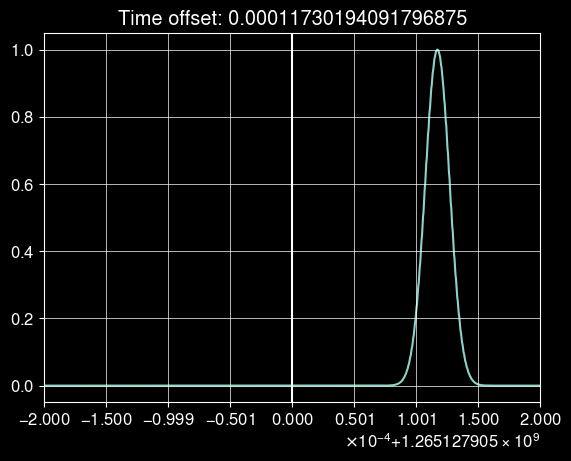

In [6]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'geocent_time', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 10000,
                 geocent_time_correction = 0.000,
                 phase_correction=0.0
        )
time_offset = results[0][np.argmax(results[1])] - results[2]
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.title(f"Time offset: {time_offset}")
plt.xlim(results[2]-0.0002, results[2]+0.0002)


In [7]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'phase', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = time_offset
        )
phase_offset = results[0][np.argmax(results[1])] - results[2]

08:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:07 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

Text(0.5, 1.0, 'phase offset: -0.00016694490818025542')

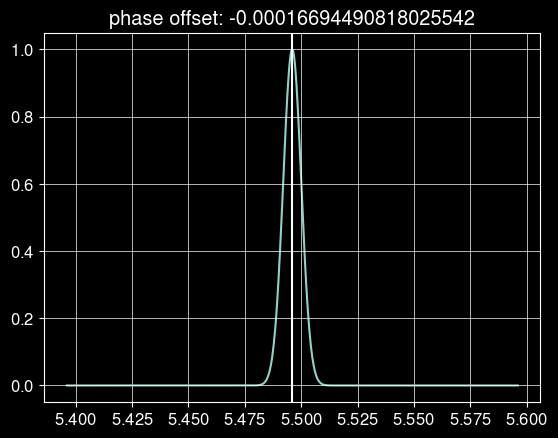

In [8]:
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.title(f"phase offset: {phase_offset}")

## Feeding the offset back in the pe of other parameters

We saw above that the the offset needed in time is :  0.00011706352233886719. We do it below.

#### It fixes the bias in the chirpmass

In [9]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'chirp_mass', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 500,
                 geocent_time_correction = time_offset,
                 phase_correction=phase_offset
        )

08:09 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:09 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/500 [00:00<?, ?it/s]

(11.715852347809129, 11.735852347809129)

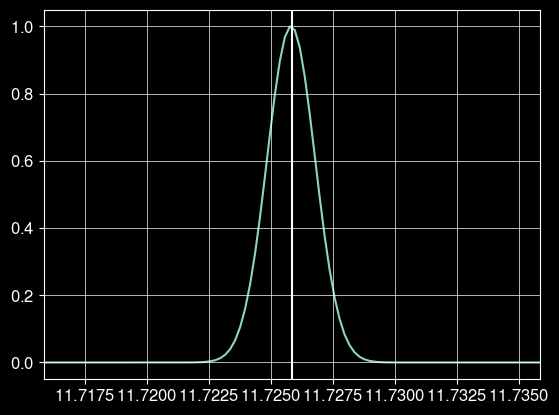

In [10]:
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.01, results[2]+0.01)

08:09 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:09 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/1000 [00:00<?, ?it/s]

(0.927863311523898, 0.947863311523898)

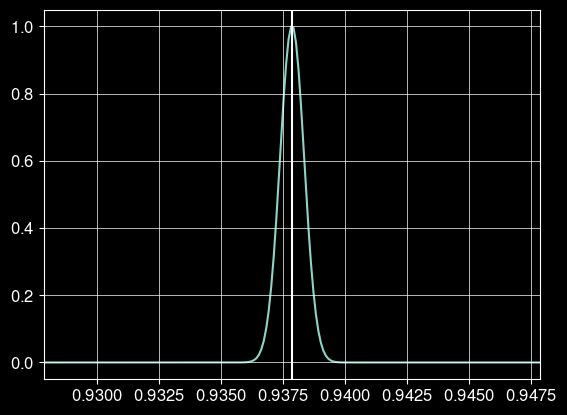

In [11]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'mass_ratio', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 1000,
                 geocent_time_correction = time_offset,
                 phase_correction=phase_offset
        )
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.01, results[2]+0.01)

In [12]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'luminosity_distance', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = time_offset,
                 phase_correction=phase_offset
        )

08:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

(18.645249211791665, 20.645249211791665)

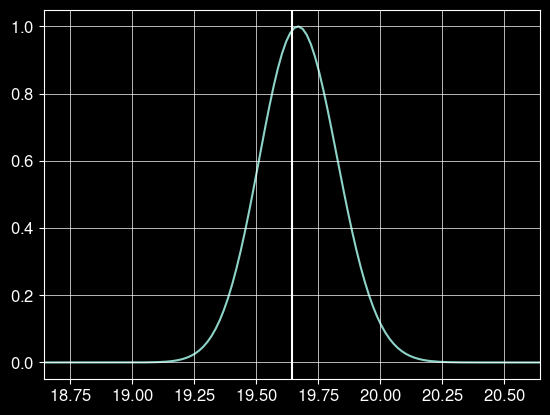

In [13]:
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-1, results[2]+1)

## Try phase offset alone without time offset (found not effective)

In [14]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'phase', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = 0,
                 phase_correction=0
        )
phase_offset = results[0][np.argmax(results[1])] - results[2]

08:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

(5.396084823244369, 5.546084823244368)

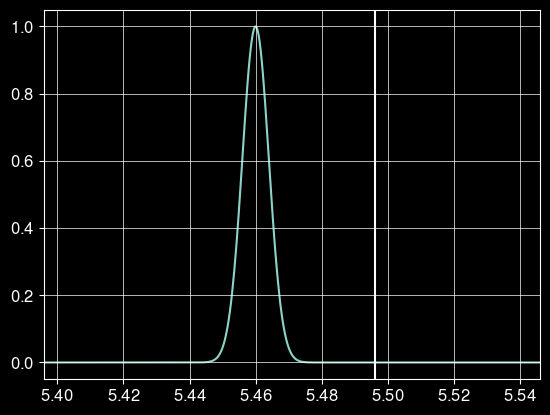

In [17]:
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.1, results[2]+0.05)

In [18]:
phase_offset

-0.0362270450751252

08:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:59 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/5000 [00:00<?, ?it/s]

(1265127904.9995, 1265127905.0005)

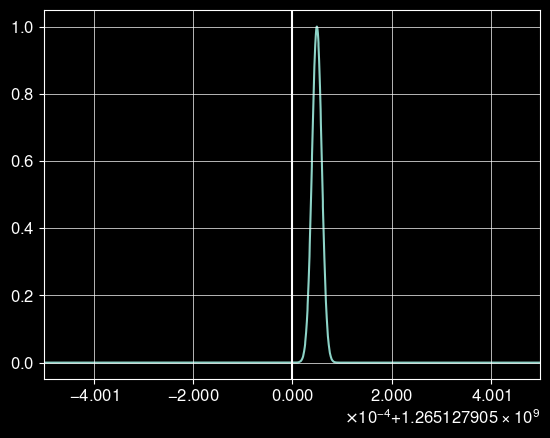

In [23]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'geocent_time', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 5000,
                 geocent_time_correction = 0,
                 phase_correction=phase_offset
        )
time_offset = results[0][np.argmax(results[1])] - results[2]

plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.0005, results[2]+0.0005)

In [24]:
time_offset

4.935264587402344e-05

09:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:01 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

(18.645249211791665, 20.645249211791665)

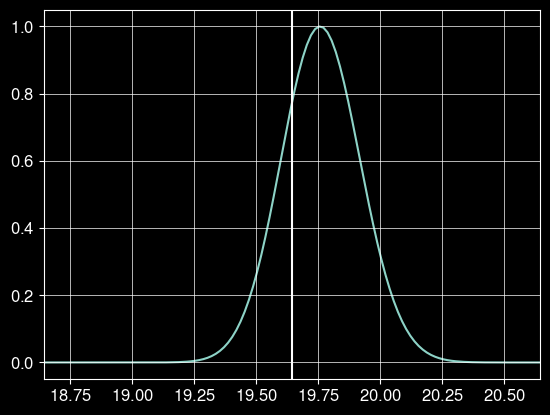

In [26]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'luminosity_distance', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = 0,
                 phase_correction=0
        )

plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-1, results[2]+1)

## time and ra offsets

09:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

09:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

09:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

(18.645249211791665, 20.645249211791665)

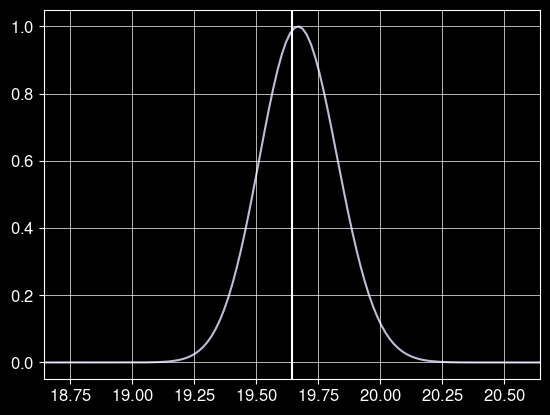

In [6]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'geocent_time', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = 0,
                 phase_correction=0,
                 ra_correction=0
        )
time_offset = results[0][np.argmax(results[1])] - results[2]
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.001, results[2]+0.001)

results = pe_on_grid (inj_idx = 10,
                 theta = 'ra', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = time_offset,
                 phase_correction=0,
                 ra_correction=0
        )
ra_offset = results[0][np.argmax(results[1])] - results[2]
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.001, results[2]+0.001)

results = pe_on_grid (inj_idx = 10,
                 theta = 'luminosity_distance', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = time_offset,
                 phase_correction=0,
                 ra_correction=ra_offset
        )
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-1, results[2]+1)



10:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
10:59 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

(0.5123989018538194, 0.5323989018538194)

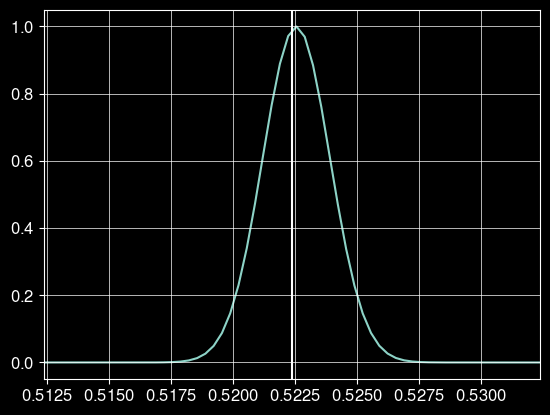

In [7]:
results = pe_on_grid (inj_idx = 10,
                 theta = 'dec', 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = time_offset,
                 phase_correction=0,
                 ra_correction=0
        )
ra_offset = results[0][np.argmax(results[1])] - results[2]
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.01, results[2]+0.01)



13:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:49 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:49 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:49 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:50 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:50 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:51 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:51 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:51 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:51 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:51 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

13:52 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:52 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


  0%|          | 0/600 [00:00<?, ?it/s]

ValueError: num must be an integer with 1 <= num <= 12, not 13

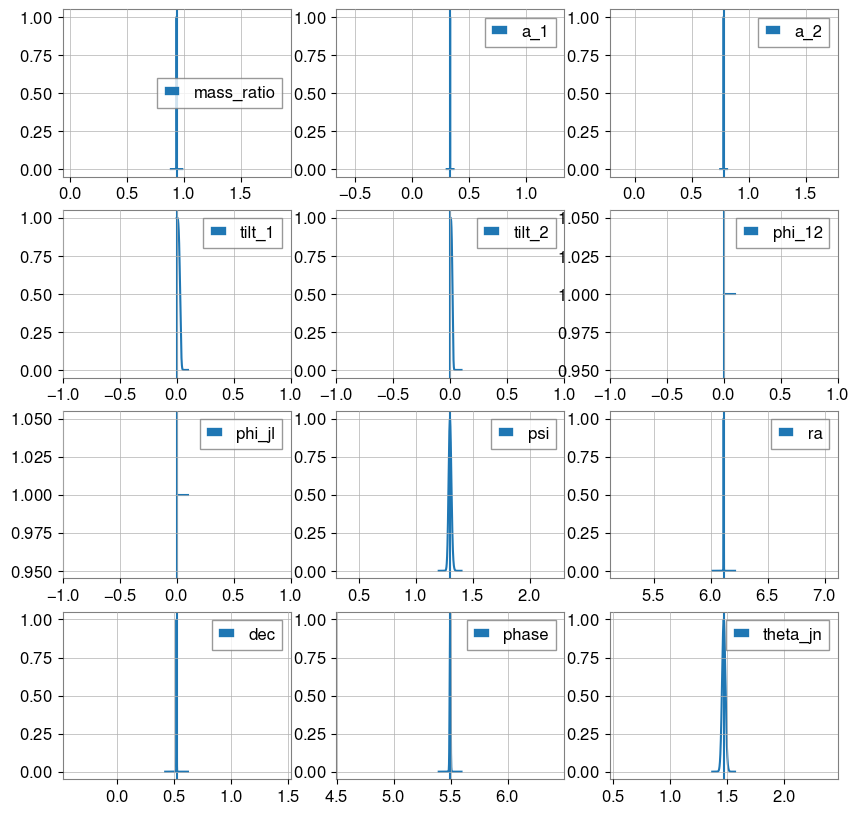

In [64]:
plt.figure(figsize=(10,10))
index = 1
for parameter in ['mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']:


    results = pe_on_grid (inj_idx = 10,
                 theta = parameter, 
                 injections = injections,
                 analysis_data_frame = signal_only,
                 analysis_data_channel = channel_INJ,
                 psd_data_frame = org_noise_only,
                 psd_data_channel = channel,
                 psd_file = './gwpy_psd_original.txt',
                 det = "V1",
                 duration = 4,
                 postmerger_duration = 1,
                 psd_duration = 512,
                 sampling_frequency = 2048,
                 minimum_frequency = 20,
                 maximum_frequency = 800,
                 reference_frequency = 20,
                 waveform_approximant="IMRPhenomPv2",
                 grid_size= 600,
                 geocent_time_correction = 0.00011730194091796875
        )

    plt.subplot(4,3,index)
    plt.plot(results[0], results[1])
    plt.axvline(results[2])
    plt.xlim(results[2]-1, results[2]+1)
    plt.legend([parameter])
    index +=1 

In [72]:
psd_file = './gwpy_psd_deepclean.txt'
if psd_data_frame is not None:
    if psd_data_channel == None:
        psd_data = TimeSeries.read(
            psd_data_frame, 
            start = psd_start_time, 
            end = psd_end_time
        )
    else:
        psd_data = TimeSeries.read(
            psd_data_frame, psd_data_channel, 
            start = psd_start_time, 
            end = psd_end_time
        )

    psd_gwpy = get_gwpy_mean_psd (
        psd_data, 
        fs = sampling_frequency, 
        low_frequency=minimum_frequency,
        fftlength=32, 
        method = 'welch'
    )

    np.savetxt(
        fname = psd_file, 
        X = np.array([ psd_gwpy[0][:-1], psd_gwpy[1][:-1] ]).T
    )

## offset calculation for a different injection

11:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:59 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.170967102050781e-05


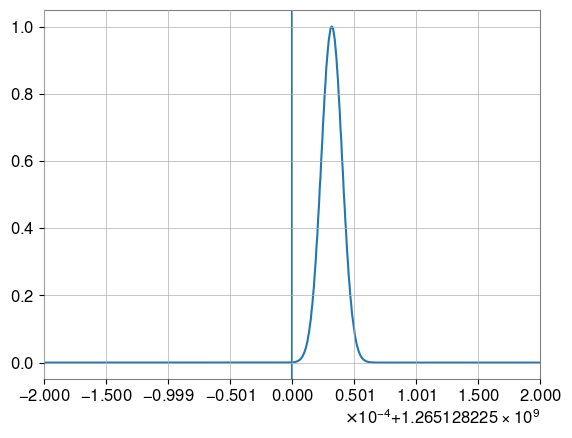

In [64]:
inj_idx = 20
analysis_data_frame = signal_only
analysis_data_channel = channel_INJ
psd_data_frame = org_noise_only
psd_data_channel = channel
det = "V1"
duration = 4
postmerger_duration = 1
psd_duration = 512
sampling_frequency = 4096
minimum_frequency = 10
maximum_frequency = 2048
reference_frequency = 20
geocent_time_correction = 0
psd_file = './gwpy_psd_original.txt'

injection_parameters = injections.iloc[inj_idx].to_dict()
#injection_parameters['geocent_time'] =  injection_parameters['geocent_time'] # + geocent_time_correction
param_dict = injection_parameters

mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


trigger_time= injections['geocent_time'][inj_idx] #+ geocent_time_correction ## FIX
premerger_duration = duration - postmerger_duration
start_time = trigger_time - premerger_duration
end_time   = start_time + duration
psd_start_time = start_time + 8
psd_end_time = psd_start_time + psd_duration
#trigger_time = end_time - 1

waveform_approximant="IMRPhenomPv2"

if analysis_data_channel == None:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        start = start_time, 
        end = end_time
    )
else:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        analysis_data_channel,
        start = start_time, 
        end = end_time
    )

waveform_arguments=dict(minimum_frequency=10.0)
params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
chirp_time = lalsim.SimInspiralChirpTimeBound(
    10,
    params_new["mass_1"] * lal.MSUN_SI,
    params_new["mass_2"] * lal.MSUN_SI,
    params_new["a_1"] * np.cos(params_new["tilt_1"]),
    params_new["a_2"] * np.cos(params_new["tilt_2"]),
)
chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
offset_parameter = 0.2  ## FIX
waveform_generator = bilby.gw.WaveformGenerator(
    duration=chirp_time,
    sampling_frequency=sampling_frequency,
    start_time=injection_parameters["geocent_time"] + offset_parameter - chirp_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(minimum_frequency=10.0),
)

ifos = bilby.gw.detector.InterferometerList([det])
ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
ifos[0].power_spectral_density.psd_file = psd_file

time_min = injection_parameters['geocent_time']-0.001
time_max = injection_parameters['geocent_time']+0.001


priors = BBHPriorDict()
# priors['chirp_mass']  = bilby.core.prior.Uniform(
#     name='chirp_mass', minimum=mc_prior_min, maximum=mc_prior_max, unit='$M_{\odot}$', boundary='reflective')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']:
    priors[key] = injection_parameters[key]  ## FIX
    
priors['geocent_time'] = bilby.core.prior.Uniform(
     name='geocent_time', 
     minimum= time_min, 
     maximum= time_max, 
     boundary='reflective')
priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])
priors['chirp_mass'] = mc_inj

likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, 
        waveform_generator=waveform_generator,
        reference_frame= 'sky',
        time_reference= 'geocent',
        time_marginalization = False,
        distance_marginalization = False, 
        jitter_time= False,
        phase_marginalization = False,
        priors = priors)    


grid = np.linspace(time_min, time_max,3000)
LLR = np.zeros(grid.shape)

mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_inj,mass_ratio)
m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
param_dict['mass_1'] = m1
param_dict['mass_2'] = m2

for i in range(len(LLR)):
    param_dict['geocent_time'] = grid[i]
    likelihood.parameters = param_dict

    LLR[i] = likelihood.log_likelihood_ratio()

posterior = np.exp(LLR-max(LLR))
plt.plot(grid, posterior)
plt.axvline(trigger_time)
plt.xlim(trigger_time-0.0002, trigger_time+0.0002)
print("the offset in time is : ", grid[np.argmax(posterior)] - trigger_time)

In [67]:
inj_idx = 20
analysis_data_frame = signal_only
analysis_data_channel = channel_INJ
psd_data_frame = org_noise_only
psd_data_channel = channel
det = "V1"
duration = 4
postmerger_duration = 1
psd_duration = 512
sampling_frequency = 4096
minimum_frequency = 10
maximum_frequency = 2048
reference_frequency = 20
#geocent_time_correction = 0.00011706352233886719
geocent_time_correction = 3.170967102050781e-05
psd_file = './gwpy_psd_original.txt'

injection_parameters = injections.iloc[inj_idx].to_dict()
injection_parameters['geocent_time'] =  injection_parameters['geocent_time']  + geocent_time_correction
param_dict = injection_parameters

mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


trigger_time= injections['geocent_time'][inj_idx] #+ geocent_time_correction ## FIX
premerger_duration = duration - postmerger_duration
start_time = trigger_time - premerger_duration
end_time   = start_time + duration
psd_start_time = start_time + 8
psd_end_time = psd_start_time + psd_duration
#trigger_time = end_time - 1

waveform_approximant="IMRPhenomPv2"

if analysis_data_channel == None:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        start = start_time, 
        end = end_time
    )
else:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        analysis_data_channel,
        start = start_time, 
        end = end_time
    )

waveform_arguments=dict(minimum_frequency=10.0)
params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
chirp_time = lalsim.SimInspiralChirpTimeBound(
    10,
    params_new["mass_1"] * lal.MSUN_SI,
    params_new["mass_2"] * lal.MSUN_SI,
    params_new["a_1"] * np.cos(params_new["tilt_1"]),
    params_new["a_2"] * np.cos(params_new["tilt_2"]),
)
chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
offset_parameter = 0.2  ## FIX
waveform_generator = bilby.gw.WaveformGenerator(
    duration=chirp_time,
    sampling_frequency=sampling_frequency,
    start_time=injection_parameters["geocent_time"] + offset_parameter - chirp_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(minimum_frequency=10.0),
)

ifos = bilby.gw.detector.InterferometerList([det])
ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
ifos[0].power_spectral_density.psd_file = psd_file

mc_prior_min = mc_inj - 0.03
mc_prior_max = mc_inj + 0.03


priors = BBHPriorDict()
priors['chirp_mass']  = bilby.core.prior.Uniform(
    name='chirp_mass', minimum=mc_prior_min, maximum=mc_prior_max, unit='$M_{\odot}$', boundary='reflective')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']:
    priors[key] = injection_parameters[key]  ## FIX
    
priors['geocent_time'] = injection_parameters['geocent_time'] 
priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])

likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, 
        waveform_generator=waveform_generator,
        reference_frame= 'sky',
        time_reference= 'geocent',
        time_marginalization = False,
        distance_marginalization = False, 
        jitter_time= False,
        phase_marginalization = False,
        priors = priors)    


Mc_min = max(5, mc_inj - 0.03)
Mc_max = min(90, mc_inj + 0.03)
mc_grid = np.linspace(Mc_min, Mc_max,1000)
LLR = np.zeros(mc_grid.shape)

for i in range(len(LLR)):
    mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
    mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_grid[i],mass_ratio)
    m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
    param_dict['mass_1'] = m1
    param_dict['mass_2'] = m2
    likelihood.parameters = param_dict

    LLR[i] = likelihood.log_likelihood_ratio()

12:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:02 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


(11.476342352738358, 11.496342352738358)

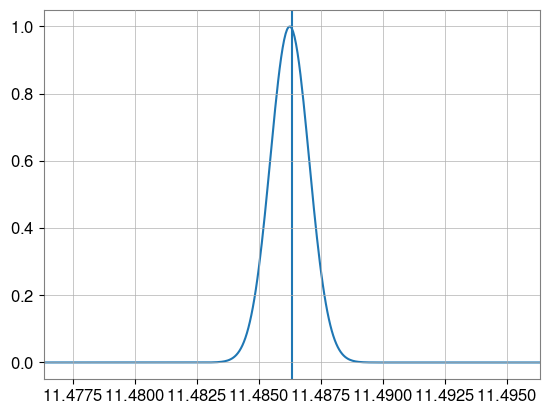

In [68]:
plt.plot(mc_grid, np.exp(LLR-max(LLR)))
plt.axvline(mc_inj)
plt.xlim(mc_inj-0.01, mc_inj+0.01)

## Recovering one with noise but before DeepClean application

In [69]:
inj_idx = 20
analysis_data_frame = org_noise_plus_signal
analysis_data_channel = channel
psd_data_frame = org_noise_only
psd_data_channel = channel
det = "V1"
duration = 4
postmerger_duration = 1
psd_duration = 512
sampling_frequency = 4096
minimum_frequency = 10
maximum_frequency = 2048
reference_frequency = 20
#geocent_time_correction = 0.00011706352233886719
geocent_time_correction = 3.170967102050781e-05
psd_file = './gwpy_psd_original.txt'

injection_parameters = injections.iloc[inj_idx].to_dict()
injection_parameters['geocent_time'] =  injection_parameters['geocent_time']  + geocent_time_correction
param_dict = injection_parameters

mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


trigger_time= injections['geocent_time'][inj_idx] #+ geocent_time_correction ## FIX
premerger_duration = duration - postmerger_duration
start_time = trigger_time - premerger_duration
end_time   = start_time + duration
psd_start_time = start_time + 8
psd_end_time = psd_start_time + psd_duration
#trigger_time = end_time - 1

waveform_approximant="IMRPhenomPv2"

if analysis_data_channel == None:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        start = start_time, 
        end = end_time
    )
else:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        analysis_data_channel,
        start = start_time, 
        end = end_time
    )

waveform_arguments=dict(minimum_frequency=10.0)
params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
chirp_time = lalsim.SimInspiralChirpTimeBound(
    10,
    params_new["mass_1"] * lal.MSUN_SI,
    params_new["mass_2"] * lal.MSUN_SI,
    params_new["a_1"] * np.cos(params_new["tilt_1"]),
    params_new["a_2"] * np.cos(params_new["tilt_2"]),
)
chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
offset_parameter = 0.2  ## FIX
waveform_generator = bilby.gw.WaveformGenerator(
    duration=chirp_time,
    sampling_frequency=sampling_frequency,
    start_time=injection_parameters["geocent_time"] + offset_parameter - chirp_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(minimum_frequency=10.0),
)

ifos = bilby.gw.detector.InterferometerList([det])
ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
ifos[0].power_spectral_density.psd_file = psd_file

mc_prior_min = mc_inj - 0.03
mc_prior_max = mc_inj + 0.03


priors = BBHPriorDict()
priors['chirp_mass']  = bilby.core.prior.Uniform(
    name='chirp_mass', minimum=mc_prior_min, maximum=mc_prior_max, unit='$M_{\odot}$', boundary='reflective')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']:
    priors[key] = injection_parameters[key]  ## FIX
    
priors['geocent_time'] = injection_parameters['geocent_time'] 
priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])

likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, 
        waveform_generator=waveform_generator,
        reference_frame= 'sky',
        time_reference= 'geocent',
        time_marginalization = False,
        distance_marginalization = False, 
        jitter_time= False,
        phase_marginalization = False,
        priors = priors)    


Mc_min = max(5, mc_inj - 0.03)
Mc_max = min(90, mc_inj + 0.03)
mc_grid = np.linspace(Mc_min, Mc_max,1000)
LLR = np.zeros(mc_grid.shape)

for i in range(len(LLR)):
    mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
    mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_grid[i],mass_ratio)
    m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
    param_dict['mass_1'] = m1
    param_dict['mass_2'] = m2
    likelihood.parameters = param_dict

    LLR[i] = likelihood.log_likelihood_ratio()

13:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:50 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


(11.476342352738358, 11.496342352738358)

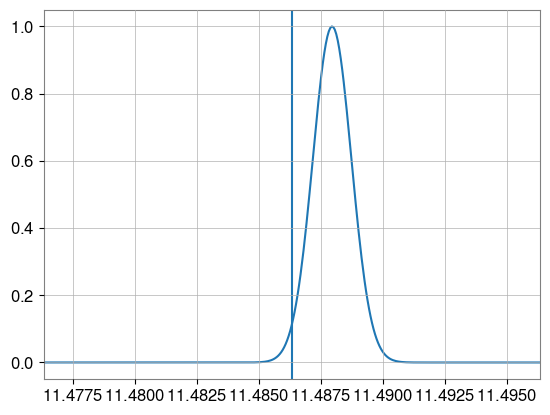

In [70]:
plt.plot(mc_grid, np.exp(LLR-max(LLR)))
plt.axvline(mc_inj)
plt.xlim(mc_inj-0.01, mc_inj+0.01)

In [75]:
inj_idx = 20
analysis_data_frame = dc_noise_plus_signal
analysis_data_channel = channel_DC
psd_data_frame = org_noise_only
psd_data_channel = channel
det = "V1"
duration = 4
postmerger_duration = 1
psd_duration = 512
sampling_frequency = 4096
minimum_frequency = 10
maximum_frequency = 2048
reference_frequency = 20
#geocent_time_correction = 0.00011706352233886719
geocent_time_correction = 3.170967102050781e-05
psd_file = './gwpy_psd_deepclean.txt'

injection_parameters = injections.iloc[inj_idx].to_dict()
injection_parameters['geocent_time'] =  injection_parameters['geocent_time']  + geocent_time_correction
param_dict = injection_parameters

mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


trigger_time= injections['geocent_time'][inj_idx] #+ geocent_time_correction ## FIX
premerger_duration = duration - postmerger_duration
start_time = trigger_time - premerger_duration
end_time   = start_time + duration
psd_start_time = start_time + 8
psd_end_time = psd_start_time + psd_duration
#trigger_time = end_time - 1

waveform_approximant="IMRPhenomPv2"

if analysis_data_channel == None:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        start = start_time, 
        end = end_time
    )
else:
    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        analysis_data_channel,
        start = start_time, 
        end = end_time
    )

waveform_arguments=dict(minimum_frequency=10.0)
params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
chirp_time = lalsim.SimInspiralChirpTimeBound(
    10,
    params_new["mass_1"] * lal.MSUN_SI,
    params_new["mass_2"] * lal.MSUN_SI,
    params_new["a_1"] * np.cos(params_new["tilt_1"]),
    params_new["a_2"] * np.cos(params_new["tilt_2"]),
)
chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
offset_parameter = 0.2  ## FIX
waveform_generator = bilby.gw.WaveformGenerator(
    duration=chirp_time,
    sampling_frequency=sampling_frequency,
    start_time=injection_parameters["geocent_time"] + offset_parameter - chirp_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(minimum_frequency=10.0),
)

ifos = bilby.gw.detector.InterferometerList([det])
ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
ifos[0].power_spectral_density.psd_file = psd_file

mc_prior_min = mc_inj - 0.03
mc_prior_max = mc_inj + 0.03


priors = BBHPriorDict()
priors['chirp_mass']  = bilby.core.prior.Uniform(
    name='chirp_mass', minimum=mc_prior_min, maximum=mc_prior_max, unit='$M_{\odot}$', boundary='reflective')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance']:
    priors[key] = injection_parameters[key]  ## FIX
    
priors['geocent_time'] = injection_parameters['geocent_time'] 
priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])

likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, 
        waveform_generator=waveform_generator,
        reference_frame= 'sky',
        time_reference= 'geocent',
        time_marginalization = False,
        distance_marginalization = False, 
        jitter_time= False,
        phase_marginalization = False,
        priors = priors)    


Mc_min = max(5, mc_inj - 0.03)
Mc_max = min(90, mc_inj + 0.03)
mc_grid = np.linspace(Mc_min, Mc_max,1000)
LLR = np.zeros(mc_grid.shape)

for i in range(len(LLR)):
    mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
    mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_grid[i],mass_ratio)
    m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
    param_dict['mass_1'] = m1
    param_dict['mass_2'] = m2
    likelihood.parameters = param_dict

    LLR[i] = likelihood.log_likelihood_ratio()

13:58 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:58 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


(11.476342352738358, 11.496342352738358)

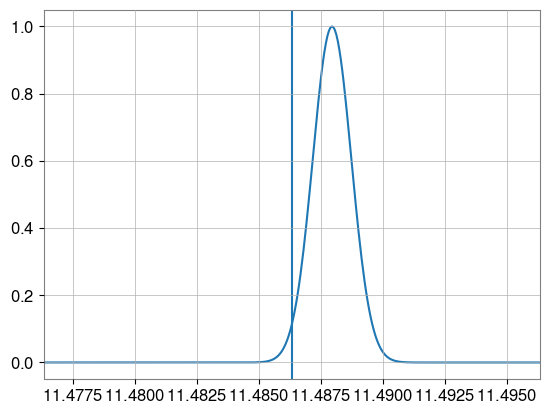

In [76]:
plt.plot(mc_grid, np.exp(LLR-max(LLR)))
plt.axvline(mc_inj)
plt.xlim(mc_inj-0.01, mc_inj+0.01)

## find corrections for all the injections

  0%|          | 0/127 [00:00<?, ?it/s]

15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00016617774963378906


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.8133392333984375e-05


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.9325485229492188e-05


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.6716461181640625e-05


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.7404556274414062e-05


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -7.033348083496094e-05


15:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:35 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.463859558105469e-05


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.000141143798828125


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -7.033348083496094e-05


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00011706352233886719


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.940696716308594e-05


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001697540283203125


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00016379356384277344


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.67572021484375e-06


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00011706352233886719


15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:36 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -9.059906005859375e-06


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.09808349609375e-05


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00010013580322265625


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  9.894371032714844e-05


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.170967102050781e-05


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.225440979003906e-05


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001289844512939453


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00016498565673828125


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00016379356384277344


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -5.1021575927734375e-05


15:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:37 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00011706352233886719


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -3.790855407714844e-05


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.152557373046875e-07


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00013017654418945312


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00013494491577148438


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00010132789611816406


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00012540817260742188


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00016617774963378906


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.029273986816406e-05


15:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:38 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.621246337890625e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -5.221366882324219e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.910064697265625e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -7.867813110351562e-06


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.532669067382812e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00010013580322265625


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.225440979003906e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.09808349609375e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  9.5367431640625e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.574920654296875e-05


15:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:39 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -3.790855407714844e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001361370086669922


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -2.2172927856445312e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00011110305786132812


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.987022399902344e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.5020370483398438e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00015783309936523438


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  4.267692565917969e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  9.655952453613281e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  4.982948303222656e-05


15:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:40 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.890296936035156e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001697540283203125


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.413459777832031e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  4.291534423828125e-06


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00015664100646972656


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.413459777832031e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -5.1021575927734375e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  5.459785461425781e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00010013580322265625


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.344650268554688e-05


15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:41 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.175041198730469e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.0994415283203125e-06


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -2.574920654296875e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.29425048828125e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.5020370483398438e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.2636184692382812e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.67572021484375e-06


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.890296936035156e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.5020370483398438e-05


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00012421607971191406


15:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:42 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  9.655952453613281e-05


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.867813110351562e-06


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.0251998901367188e-05


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00010251998901367188


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -2.6941299438476562e-05


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00012183189392089844


15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001049041748046875


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.413459777832031e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.0558319091796875e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001087188720703125


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.170967102050781e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00014591217041015625


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.38690185546875e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.6253204345703125e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.9788742065429688e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  4.1484832763671875e-05


15:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.8596649169921875e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.267692565917969e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  5.698204040527344e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001697540283203125


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.863739013671875e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.0001385211944580078


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.987022399902344e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00013375282287597656


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.2901763916015625e-05


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00013375282287597656


15:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.2901763916015625e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00012421607971191406


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00015306472778320312


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  0.00013017654418945312


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.175041198730469e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.175041198730469e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.033348083496094e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.0558319091796875e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  8.463859558105469e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  9.417533874511719e-05


15:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:46 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.9325485229492188e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  6.413459777832031e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.621246337890625e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -5.5789947509765625e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -6.771087646484375e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -4.506111145019531e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.9788742065429688e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -3.552436828613281e-05


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.9073486328125e-06


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.867813110351562e-06


15:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:47 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -2.6941299438476562e-05


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  7.152557373046875e-07


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  3.552436828613281e-05


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  1.5020370483398438e-05


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  2.574920654296875e-05


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.621246337890625e-05


15:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:48 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


the offset in time is :  -1.621246337890625e-05


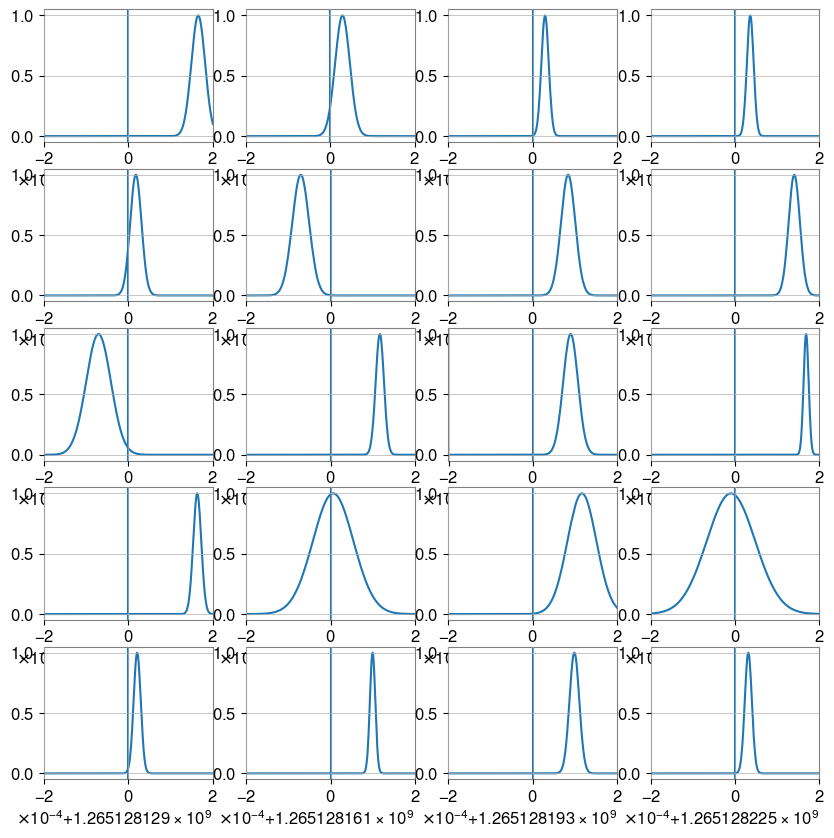

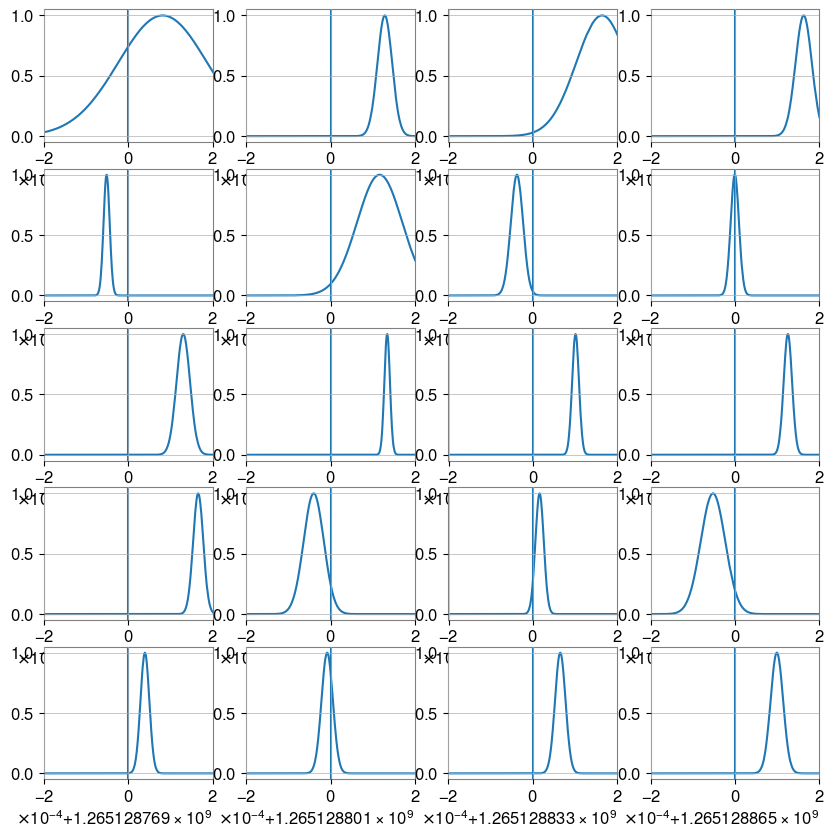

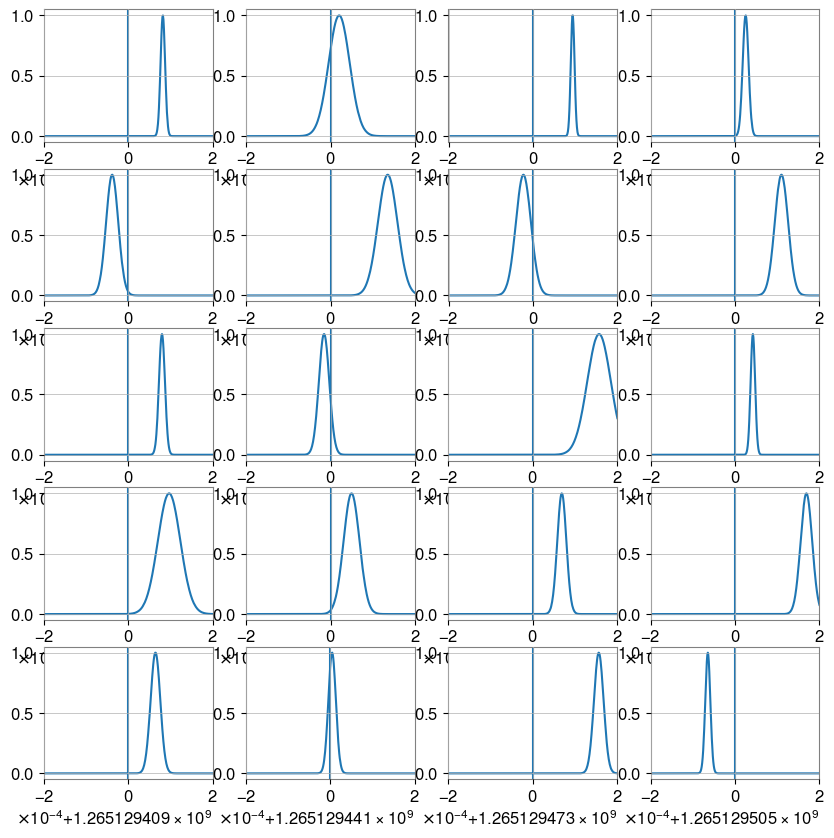

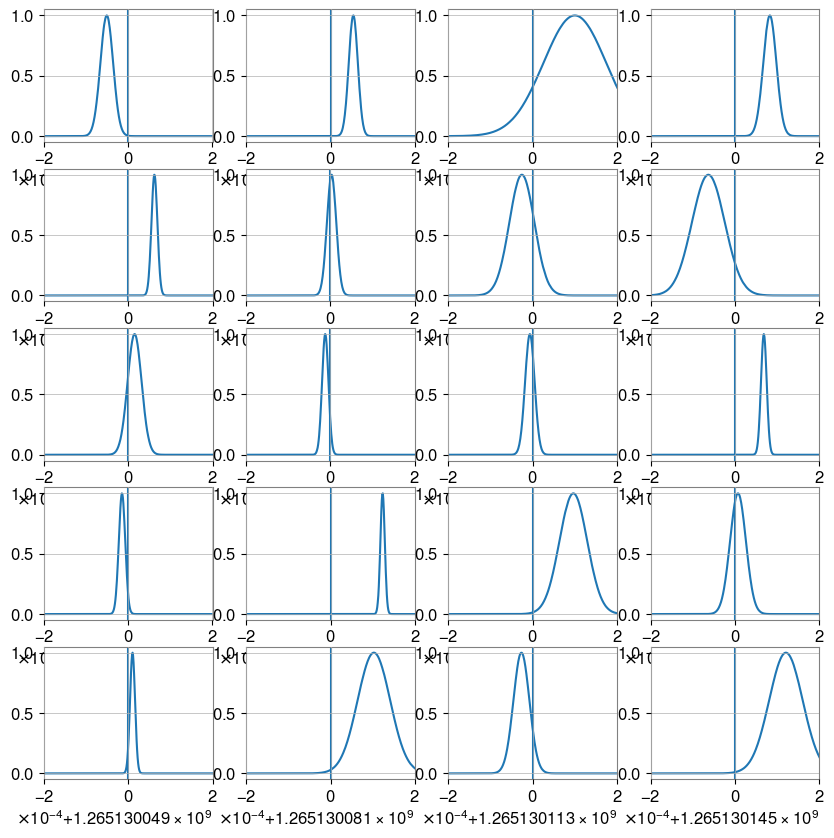

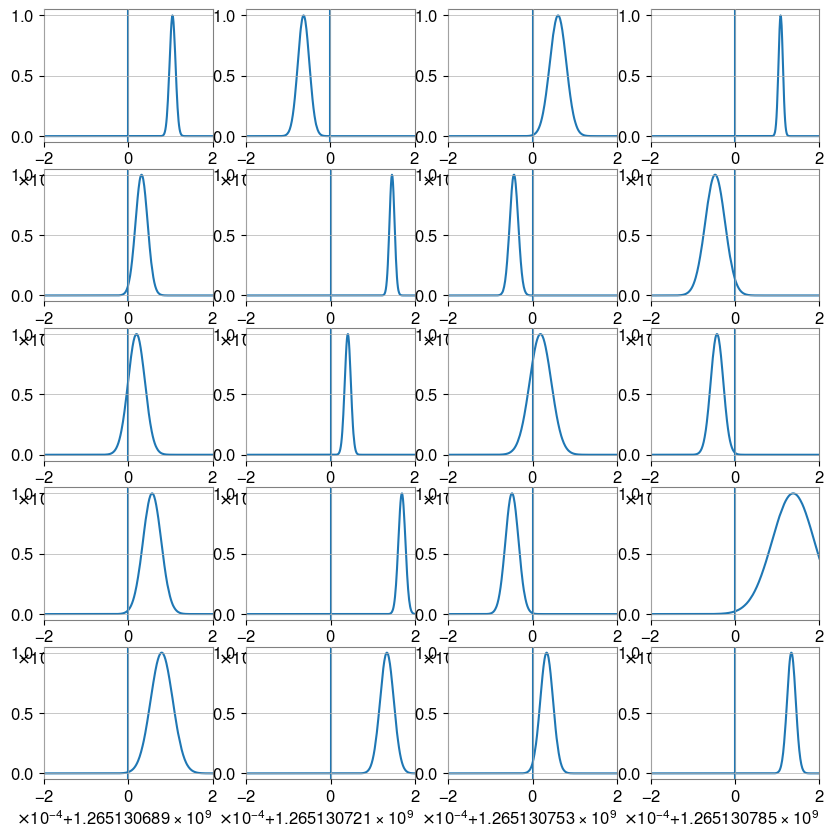

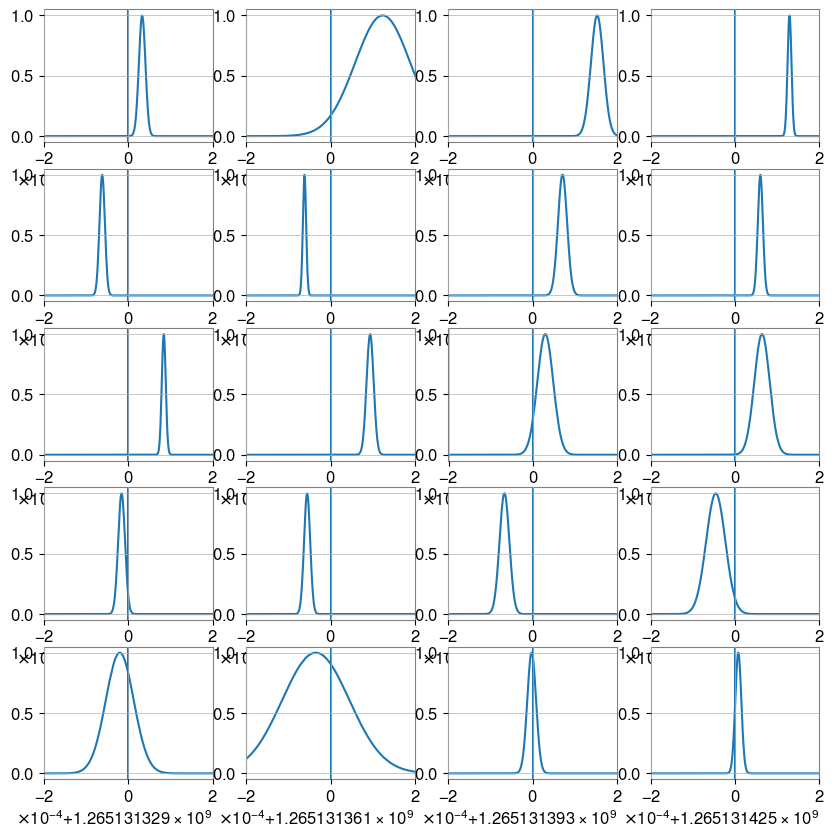

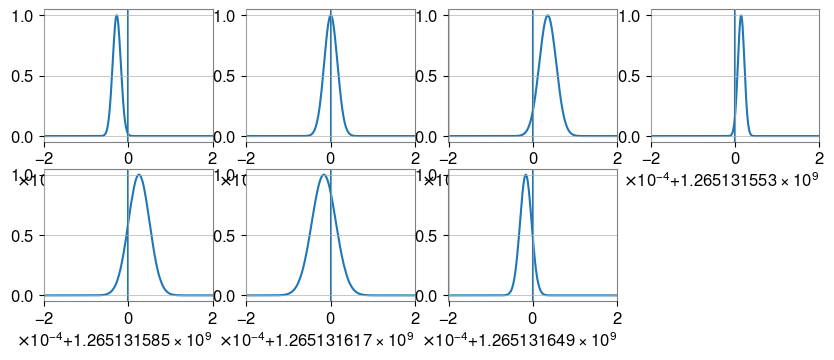

In [89]:
analysis_data_frame = signal_only
analysis_data_channel = channel_INJ
psd_data_frame = org_noise_only
psd_data_channel = channel
det = "V1"
duration = 4
postmerger_duration = 1
psd_duration = 512
sampling_frequency = 4096
minimum_frequency = 10
maximum_frequency = 2048
reference_frequency = 20
geocent_time_correction = 0
psd_file = './gwpy_psd_original.txt'
waveform_approximant="IMRPhenomPv2"

time_offsets = np.zeros([128])
for inj_idx in trange(1,128):
    injection_parameters = injections.iloc[inj_idx].to_dict()
    param_dict = injection_parameters

    mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
    z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


    trigger_time= injections['geocent_time'][inj_idx] #+ geocent_time_correction ## FIX
    premerger_duration = duration - postmerger_duration
    start_time = trigger_time - premerger_duration
    end_time   = start_time + duration


    analysis_data = TimeSeries.read(
        analysis_data_frame, 
        analysis_data_channel,
        start = start_time, 
        end = end_time
    )

    waveform_arguments=dict(minimum_frequency=10.0)
    params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
    chirp_time = lalsim.SimInspiralChirpTimeBound(
        10,
        params_new["mass_1"] * lal.MSUN_SI,
        params_new["mass_2"] * lal.MSUN_SI,
        params_new["a_1"] * np.cos(params_new["tilt_1"]),
        params_new["a_2"] * np.cos(params_new["tilt_2"]),
    )

    chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), duration)
    offset_parameter = 0.2  ## FIX
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=chirp_time,
        sampling_frequency=sampling_frequency,
        start_time=injection_parameters["geocent_time"] + offset_parameter - chirp_time,
        frequency_domain_source_model=lal_binary_black_hole,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(minimum_frequency=10.0),
    )

    ifos = bilby.gw.detector.InterferometerList([det])
    ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
    ifos[0].power_spectral_density.psd_file = psd_file

    time_min = injection_parameters['geocent_time']-0.003
    time_max = injection_parameters['geocent_time']+0.003


    priors = BBHPriorDict()
    # priors['chirp_mass']  = bilby.core.prior.Uniform(
    #     name='chirp_mass', minimum=mc_prior_min, maximum=mc_prior_max, unit='$M_{\odot}$', boundary='reflective')
    for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
                'dec', 'phase', 'theta_jn', 'luminosity_distance']:
        priors[key] = injection_parameters[key]  ## FIX

    priors['geocent_time'] = bilby.core.prior.Uniform(
         name='geocent_time', 
         minimum= time_min, 
         maximum= time_max, 
         boundary='reflective')
    priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])
    priors['chirp_mass'] = mc_inj

    likelihood = bilby.gw.GravitationalWaveTransient(
            interferometers=ifos, 
            waveform_generator=waveform_generator,
            reference_frame= 'sky',
            time_reference= 'geocent',
            time_marginalization = False,
            distance_marginalization = False, 
            jitter_time= False,
            phase_marginalization = False,
            priors = priors)    


    grid = np.linspace(time_min, time_max,5000)
    LLR = np.zeros(grid.shape)

    mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
    mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_inj,mass_ratio)
    m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
    param_dict['mass_1'] = m1
    param_dict['mass_2'] = m2

    for i in range(len(LLR)):
        param_dict['geocent_time'] = grid[i]
        likelihood.parameters = param_dict

        LLR[i] = likelihood.log_likelihood_ratio()

    posterior = np.exp(LLR-max(LLR))
    time_offsets[inj_idx] = grid[np.argmax(posterior)] - trigger_time
    if np.mod(inj_idx, 20) == 1:
        plt.figure(figsize=(10,10))
        subplot_idx = 1
    plt.subplot(5,4,subplot_idx)
    subplot_idx += 1
    plt.plot(grid, posterior)
    plt.axvline(trigger_time)
    plt.xlim(trigger_time-0.0002, trigger_time+0.0002)
    print("the offset in time is : ", time_offsets[inj_idx])
    
    
    

In [90]:
time_offsets

array([ 0.00000000e+00,  1.66177750e-04,  2.81333923e-05,
        2.93254852e-05,  3.67164612e-05,  1.74045563e-05,
       -7.03334808e-05,  8.46385956e-05,  1.41143799e-04,
       -7.03334808e-05,  1.17063522e-04,  8.94069672e-05,
        1.69754028e-04,  1.63793564e-04,  6.67572021e-06,
        1.17063522e-04, -9.05990601e-06,  2.09808350e-05,
        1.00135803e-04,  9.89437103e-05,  3.17096710e-05,
        8.22544098e-05,  1.28984451e-04,  1.64985657e-04,
        1.63793564e-04, -5.10215759e-05,  1.17063522e-04,
       -3.79085541e-05,  7.15255737e-07,  1.30176544e-04,
        1.34944916e-04,  1.01327896e-04,  1.25408173e-04,
        1.66177750e-04, -4.02927399e-05,  1.62124634e-05,
       -5.22136688e-05,  3.91006470e-05, -7.86781311e-06,
        6.53266907e-05,  1.00135803e-04,  8.22544098e-05,
        2.09808350e-05,  9.53674316e-05,  2.57492065e-05,
       -3.79085541e-05,  1.36137009e-04, -2.21729279e-05,
        1.11103058e-04,  7.98702240e-05, -1.50203705e-05,
        1.5783

In [91]:
np.savetxt(X = time_offsets, fname='offsets.txt')